> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (Census and Gun data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. In order to work with the data in this workspace, you also need to upload it to the workspace. To do so, click on the jupyter icon in the upper left to be taken back to the workspace directory. There should be an 'Upload' button in the upper right that will let you add your data file(s) to the workspace. You can then click on the .ipynb file name to come back here.

# Description
The data comes from the FBI's National Instant Criminal Background Check System. The NICS is used by to
determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this
system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a
purchase

## Questions:
    
    1- What is the estimated number of civilians gun registration per capita by states in 2010 and 2016?
    2- Which countries have had the highest gun registration in 2010 and 2016?
    3- What is the most purchased type of gun in 2017?

In [42]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [43]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
g = pd.read_csv('gun-data.csv')
c= pd.read_csv('u.s.-census-data.csv')

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

In [44]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
g.head()


,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [45]:
g.shape

(12485, 27)

In [46]:
g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other   

In [47]:
g.columns.values

array(['month', 'state', 'permit', 'permit_recheck', 'handgun', 'long_gun',
       'other', 'multiple', 'admin', 'prepawn_handgun', 'prepawn_long_gun',
       'prepawn_other', 'redemption_handgun', 'redemption_long_gun',
       'redemption_other', 'returned_handgun', 'returned_long_gun',
       'returned_other', 'rentals_handgun', 'rentals_long_gun',
       'private_sale_handgun', 'private_sale_long_gun',
       'private_sale_other', 'return_to_seller_handgun',
       'return_to_seller_long_gun', 'return_to_seller_other', 'totals'], dtype=object)

In [48]:
# note : census_data did not inclde guam, Puerto Rico, District Columbia,Virgin Islands, and Mariana ISlands;
# therefore, I am going to remove them to match census data
# I will merge gun_data and census_data after cleaning

In [49]:
# remove name of the colonies : Guam, Puerto Rico, District Columbia, Virgin Islands, and Mariana Islands
g = g[g.state != 'Guam']
g = g[g.state != 'Puerto Rico']
g = g[g.state != 'District of Columbia']
g = g[g.state != 'Virgin Islands']
g = g[g.state != 'Mariana Islands']  

In [50]:
#Drop all the variables I do not need ---> to calculate per capita 
g_capita = g.drop([ 'permit', 'permit_recheck', 'handgun',
       'long_gun', 'other', 'multiple', 'admin', 'prepawn_handgun',
       'prepawn_long_gun', 'prepawn_other', 'redemption_handgun',
       'redemption_long_gun', 'redemption_other', 'returned_handgun',
       'returned_long_gun', 'returned_other', 'rentals_handgun',
       'rentals_long_gun', 'private_sale_handgun',
       'private_sale_long_gun', 'private_sale_other',
       'return_to_seller_handgun', 'return_to_seller_long_gun',
       'return_to_seller_other'], axis = 1) 

In [51]:
g_capita.head() 

,month,state,totals
0,2017-09,Alabama,32019
1,2017-09,Alaska,6303
2,2017-09,Arizona,28394
3,2017-09,Arkansas,17747
4,2017-09,California,123506


In [52]:
g_capita['month'] = pd.to_datetime(g['month'])

In [53]:
g_capita.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350 entries, 0 to 12484
Data columns (total 3 columns):
month     11350 non-null datetime64[ns]
state     11350 non-null object
totals    11350 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 354.7+ KB


In [54]:
#Get all the 2010-04-01 
g_2010 = g_capita[g_capita['month'] == '2010-04-01']
g_2010.head(5) 

,month,state,totals
4895,2010-04-01,Alabama,20791
4896,2010-04-01,Alaska,6411
4897,2010-04-01,Arizona,16578
4898,2010-04-01,Arkansas,14563
4899,2010-04-01,California,80750


In [55]:
g_2010.describe() 

,totals
count,50.0000
mean,24517.7400
std,34280.1673
min,963.0000
25%,7197.5000
50%,15242.5000
75%,26335.5000
max,211261.0000


In [56]:
#Get all the 2016-07-01 
g_2016 = g_capita[g_capita['month'] == '2016-07-01' ]
g_2016.head(5) 

,month,state,totals
770,2016-07-01,Alabama,48927
771,2016-07-01,Alaska,6793
772,2016-07-01,Arizona,34496
773,2016-07-01,Arkansas,19378
774,2016-07-01,California,190218


In [57]:
g_2016.describe() 

,totals
count,50.000000
mean,43710.400000
std,61544.999748
min,1565.000000
25%,11823.000000
50%,25379.500000
75%,46008.500000
max,363085.000000


In [58]:
#Concat or inner join 2010 and 2016 to 
concat_g = pd.concat([g_2010,g_2016 ], keys=['2010-04-01', '2016-07-01'], axis = 0)
concat_g.head() 

month       state  totals
2010-04-01 4895 2010-04-01     Alabama   20791
           4896 2010-04-01      Alaska    6411
           4897 2010-04-01     Arizona   16578
           4898 2010-04-01    Arkansas   14563
           4899 2010-04-01  California   80750

In [59]:
#Reset index
concat_g.reset_index(drop=True, inplace=True) 

In [60]:
concat_g.tail(5) 

,month,state,totals
95,2016-07-01,Virginia,43574
96,2016-07-01,Washington,47887
97,2016-07-01,West Virginia,16791
98,2016-07-01,Wisconsin,38922
99,2016-07-01,Wyoming,4585


In [61]:
concat_g.head(5) 

,month,state,totals
0,2010-04-01,Alabama,20791
1,2010-04-01,Alaska,6411
2,2010-04-01,Arizona,16578
3,2010-04-01,Arkansas,14563
4,2010-04-01,California,80750


In [62]:
g.dropna(axis=0, how='any', inplace=False)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506
5,2017-09,Colorado,4356.0,0.0,15751.0,13448.0,1007.0,1062,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35873
6,2017-09,Connecticut,4343.0,673.0,4834.0,1993.0,274.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12117
7,2017-09,Delaware,275.0,0.0,1414.0,1538.0,66.0,68,0.0,0.0,...,0.0,0.0,0.0,55.0,34.0,3.0,1.0,2.0,0.0,3502
9,2017-09,Florida,10784.0,0.0,39199.0,17949.0,2319.0,1721,1.0,18.0,...,0.0,0.0,0.0,11.0,9.0,0.0,0.0,1.0,0.0,77390
10,2017-09,Georgia,12074.0,0.0,10933.0,7982.0,315.0,494,0.0,20.0,...,0.0,0.0,0.0,17.0,7.0,0.0,0.0,0.0,0.0,35371


Data Cleaning (census_data)

In [63]:
c.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [64]:
#Droppping all the columns that is not associated with gun_data and reset its index
c = c.drop(c.index[65: 85]).reset_index()

In [65]:
#Droping the first column 'Fact Note'
c = c.drop(['Fact Note'], axis =1 )

In [66]:
# All the NAs become 0.0
c= c.fillna(0.0)

In [67]:
#Transpose in order to join with gun_data in the future
c.set_index('Fact',inplace=True)
c = c.T.reset_index()

In [68]:
c.head()

Fact,index,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)",...,"All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code
0,index,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,64
1,Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,...,"374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33","""01"""
2,Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,...,"68,032","35,402","22,141","13,688","51,147","7,953","56,091",1.2,"570,640.95","""02"""
3,Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,...,"499,926","245,243","182,425","135,313","344,981","46,780","427,582",56.3,"113,594.08","""04"""
4,Arkansas,"2,988,248","2,916,025",2.50%,"2,915,918",6.40%,6.80%,23.60%,24.40%,16.30%,...,"231,959","123,158","75,962","35,982","189,029","25,915","192,988",56,"52,035.48","""05"""


In [69]:
#Rename index into state before joining 
c.rename(columns={'index':'state'},inplace = True)

In [70]:
c.head()

Fact,state,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)",...,"All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code
0,index,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,64
1,Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,...,"374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33","""01"""
2,Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,...,"68,032","35,402","22,141","13,688","51,147","7,953","56,091",1.2,"570,640.95","""02"""
3,Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,...,"499,926","245,243","182,425","135,313","344,981","46,780","427,582",56.3,"113,594.08","""04"""
4,Arkansas,"2,988,248","2,916,025",2.50%,"2,915,918",6.40%,6.80%,23.60%,24.40%,16.30%,...,"231,959","123,158","75,962","35,982","189,029","25,915","192,988",56,"52,035.48","""05"""


In [71]:
c.dropna(axis=0, how='any', inplace=False)

Fact,state,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)",...,"All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code
0,index,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,64
1,Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,...,"374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33","""01"""
2,Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,...,"68,032","35,402","22,141","13,688","51,147","7,953","56,091",1.2,"570,640.95","""02"""
3,Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,...,"499,926","245,243","182,425","135,313","344,981","46,780","427,582",56.3,"113,594.08","""04"""
4,Arkansas,"2,988,248","2,916,025",2.50%,"2,915,918",6.40%,6.80%,23.60%,24.40%,16.30%,...,"231,959","123,158","75,962","35,982","189,029","25,915","192,988",56,"52,035.48","""05"""
5,California,"39,250,017","37,254,522",5.40%,"37,253,956",6.30%,6.80%,23.20%,25.00%,13.60%,...,"3,548,449","1,852,580","1,320,085","1,619,857","1,819,107","252,377","3,176,341",239.1,"155,779.22","""06"""
6,Colorado,"5,540,545","5,029,324",10.20%,"5,029,196",6.10%,6.80%,22.80%,24.40%,13.40%,...,"547,352","284,554","194,508","85,849","442,365","51,722","469,524",48.5,"103,641.89","""08"""
7,Connecticut,"3,576,452","3,574,114",0.10%,"3,574,097",5.20%,5.70%,21.10%,22.90%,16.10%,...,"326,693","187,845","106,678","56,113","259,614","31,056","281,182",738.1,"4,842.36","""09"""
8,Delaware,"952,065","897,936",6.00%,"897,934",5.80%,6.20%,21.50%,22.90%,17.50%,...,"73,418","38,328","23,964","14,440","54,782","7,206","60,318",460.8,"1,948.54","""10"""
9,Florida,"20,612,439","18,804,592",9.60%,"18,801,310",5.50%,5.70%,20.10%,21.30%,19.90%,...,"2,100,187","1,084,885","807,817","926,112","1,121,749","185,756","1,846,686",350.6,"53,624.76","""12"""


#I need to convert all the columns state and "Population estimates, July 1, 2016,(v2016)" from object to float.
#Converting from object to float would help me to calculate the numbers

In [72]:
# Create new tables c_16
c_16 = c[['state', 'Population estimates, July 1, 2016,  (V2016)']] 
c_16.head()

Fact,state,"Population estimates, July 1, 2016, (V2016)"
0,index,0
1,Alabama,"4,863,300"
2,Alaska,"741,894"
3,Arizona,"6,931,071"
4,Arkansas,"2,988,248"


In [73]:
c_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
state                                           51 non-null object
Population estimates, July 1, 2016,  (V2016)    51 non-null object
dtypes: object(2)
memory usage: 896.0+ bytes


In [74]:
#Create a new table for c_10 
c_10 = c[['state','Population estimates base, April 1, 2010,  (V2016)']]
c_10.head()

Fact,state,"Population estimates base, April 1, 2010, (V2016)"
0,index,1
1,Alabama,"4,780,131"
2,Alaska,"710,249"
3,Arizona,"6,392,301"
4,Arkansas,"2,916,025"


In [75]:
c_16.reset_index(drop = True).head()

Fact,state,"Population estimates, July 1, 2016, (V2016)"
0,index,0
1,Alabama,"4,863,300"
2,Alaska,"741,894"
3,Arizona,"6,931,071"
4,Arkansas,"2,988,248"


Data Cleaning (Merging census_data and gun_data)

In [76]:
#Display and plan to concat 
c_10.head()

Fact,state,"Population estimates base, April 1, 2010, (V2016)"
0,index,1
1,Alabama,"4,780,131"
2,Alaska,"710,249"
3,Arizona,"6,392,301"
4,Arkansas,"2,916,025"


In [77]:
#Display c_16 and reset it
c_16.reset_index(drop = True).head()

Fact,state,"Population estimates, July 1, 2016, (V2016)"
0,index,0
1,Alabama,"4,863,300"
2,Alaska,"741,894"
3,Arizona,"6,931,071"
4,Arkansas,"2,988,248"


In [78]:
#Display gun_2010 and reset it
g_2010= g_2010.reset_index(drop= True)
g_2010.head()

,month,state,totals
0,2010-04-01,Alabama,20791
1,2010-04-01,Alaska,6411
2,2010-04-01,Arizona,16578
3,2010-04-01,Arkansas,14563
4,2010-04-01,California,80750


In [79]:
#Display it and reset it
g_2016 = g_2016.reset_index(drop= True)
g_2016.head()

,month,state,totals
0,2016-07-01,Alabama,48927
1,2016-07-01,Alaska,6793
2,2016-07-01,Arizona,34496
3,2016-07-01,Arkansas,19378
4,2016-07-01,California,190218


In [80]:
#Display concat_g; it is a cleaned version(note: only use concat for charts)
concat_g.head()

,month,state,totals
0,2010-04-01,Alabama,20791
1,2010-04-01,Alaska,6411
2,2010-04-01,Arizona,16578
3,2010-04-01,Arkansas,14563
4,2010-04-01,California,80750


In [81]:
concat_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
month     100 non-null datetime64[ns]
state     100 non-null object
totals    100 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.4+ KB


# Exploratory Data Analysis
Tip: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

## Research Question 1 (Gun per capita 2010-2016)

What is the estimated number of civilians gun registration per capita by states in 2010 and 2016?

In [82]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
census_diff = c_10.merge(c_16, on='state', how='left')
census_diff.head()

Fact,state,"Population estimates base, April 1, 2010, (V2016)","Population estimates, July 1, 2016, (V2016)"
0,index,1,0
1,Alabama,"4,780,131","4,863,300"
2,Alaska,"710,249","741,894"
3,Arizona,"6,392,301","6,931,071"
4,Arkansas,"2,916,025","2,988,248"


In [83]:
census_diff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 3 columns):
state                                                 51 non-null object
Population estimates base, April 1, 2010,  (V2016)    51 non-null object
Population estimates, July 1, 2016,  (V2016)          51 non-null object
dtypes: object(3)
memory usage: 1.6+ KB


In [84]:
# Convert into a percentage 
def percent(value):
    if value > 0.001:
        result = value *100
    return result

In [85]:
#Merge 2010 and 2016
gun_diff = g_2010.merge(g_2016, on='state', how='left')
gun_diff.head() # ---> this will be used to find gun per capita

#month_x and totals_x come from g_2010
#month_y and totals_y come from g_2016

,month_x,state,totals_x,month_y,totals_y
0,2010-04-01,Alabama,20791,2016-07-01,48927
1,2010-04-01,Alaska,6411,2016-07-01,6793
2,2010-04-01,Arizona,16578,2016-07-01,34496
3,2010-04-01,Arkansas,14563,2016-07-01,19378
4,2010-04-01,California,80750,2016-07-01,190218


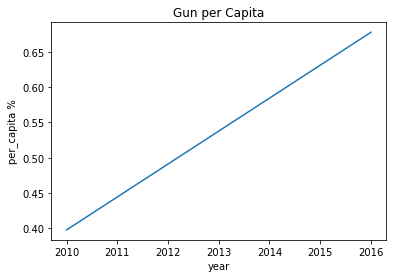

In [86]:
year = [2010, 2016]
per_capita = [0.39781331523550745, 0.67779340497762697]

plt.title('Gun per Capita')
plt.xlabel('year')
plt.ylabel('per_capita %')
plt.plot(year, per_capita)
plt.show()

## Answers :
Gun per capita in 2010 is 0.39781327392522886 %.

Gun per capita in 2016 is 0.67779340497762697 %.

## Research Question 2 (High gun by states in 2010 ,2016 and 2017)
#### Which countries have had the highest gun registration in 2010, 2016, and 2017?

In [81]:
#Now merge census_diff and gun_diff to check the connnection
gun_usa = census_diff.merge(gun_diff, on='state', how='left')
gun_usa.head()
#month_x and totals_x

,state,"Population estimates base, April 1, 2010, (V2016)","Population estimates, July 1, 2016, (V2016)",month_x,totals_x,month_y,totals_y
0,index,1,0,NaT,NaN,NaT,NaN
1,Alabama,"4,780,131","4,863,300",2010-04-01,20791.0,2016-07-01,48927.0
2,Alaska,"710,249","741,894",2010-04-01,6411.0,2016-07-01,6793.0
3,Arizona,"6,392,301","6,931,071",2010-04-01,16578.0,2016-07-01,34496.0
4,Arkansas,"2,916,025","2,988,248",2010-04-01,14563.0,2016-07-01,19378.0


In [82]:
gun_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 7 columns):
state                                                 51 non-null object
Population estimates base, April 1, 2010,  (V2016)    51 non-null object
Population estimates, July 1, 2016,  (V2016)          51 non-null object
month_x                                               50 non-null datetime64[ns]
totals_x                                              50 non-null float64
month_y                                               50 non-null datetime64[ns]
totals_y                                              50 non-null float64
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 3.2+ KB


In [83]:
#Bring back the the previous dataframe 
g.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [84]:
g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350 entries, 0 to 12484
Data columns (total 27 columns):
month                        11350 non-null object
state                        11350 non-null object
permit                       11348 non-null float64
permit_recheck               1000 non-null float64
handgun                      11350 non-null float64
long_gun                     11350 non-null float64
other                        5000 non-null float64
multiple                     11350 non-null int64
admin                        11348 non-null float64
prepawn_handgun              9597 non-null float64
prepawn_long_gun             9595 non-null float64
prepawn_other                4650 non-null float64
redemption_handgun           9600 non-null float64
redemption_long_gun          9598 non-null float64
redemption_other             4650 non-null float64
returned_handgun             2000 non-null float64
returned_long_gun            1950 non-null float64
returned_other       

In [85]:
#Make a new table 2017 
g_017 = g[g['month'] == '2017-09' ]
g_017.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [86]:
g_017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 54
Data columns (total 27 columns):
month                        50 non-null object
state                        50 non-null object
permit                       50 non-null float64
permit_recheck               50 non-null float64
handgun                      50 non-null float64
long_gun                     50 non-null float64
other                        50 non-null float64
multiple                     50 non-null int64
admin                        50 non-null float64
prepawn_handgun              50 non-null float64
prepawn_long_gun             50 non-null float64
prepawn_other                50 non-null float64
redemption_handgun           50 non-null float64
redemption_long_gun          50 non-null float64
redemption_other             50 non-null float64
returned_handgun             50 non-null float64
returned_long_gun            50 non-null float64
returned_other               50 non-null float64
rentals_handgun    

In [87]:
#Sort it in the opposite direction 
g_017.sort_values(by=['totals'], axis = 0, ascending = False).head(10)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
18,2017-09,Kentucky,378384.0,0.0,8112.0,7543.0,253.0,543,1.0,16.0,...,0.0,0.0,0.0,21.0,19.0,1.0,2.0,1.0,0.0,398706
46,2017-09,Texas,31390.0,0.0,39119.0,39416.0,2768.0,2473,0.0,59.0,...,0.0,0.0,0.0,121.0,87.0,13.0,2.0,5.0,0.0,128260
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506
14,2017-09,Illinois,15712.0,71432.0,18290.0,10201.0,0.0,814,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116449
9,2017-09,Florida,10784.0,0.0,39199.0,17949.0,2319.0,1721,1.0,18.0,...,0.0,0.0,0.0,11.0,9.0,0.0,0.0,1.0,0.0,77390
40,2017-09,Pennsylvania,23144.0,0.0,39825.0,13222.0,48.0,0,179.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77003
45,2017-09,Tennessee,16887.0,0.0,19219.0,13746.0,1042.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50945
37,2017-09,Ohio,8741.0,490.0,21085.0,14998.0,1202.0,1026,0.0,9.0,...,0.0,0.0,0.0,58.0,36.0,4.0,1.0,1.0,0.0,49942
15,2017-09,Indiana,18241.0,0.0,16093.0,11332.0,1123.0,597,79.0,5.0,...,0.0,0.0,0.0,75.0,57.0,6.0,4.0,4.0,0.0,48524
25,2017-09,Minnesota,25645.0,0.0,4862.0,12677.0,346.0,273,0.0,1.0,...,1.0,0.0,0.0,13.0,16.0,0.0,0.0,1.0,1.0,44552


List of 10 high gun by states in 2017

Kentucky
Texas
California
Illinois
Florida
Pennsylvania
Tennessee
Ohio
Indianna
Minnesota

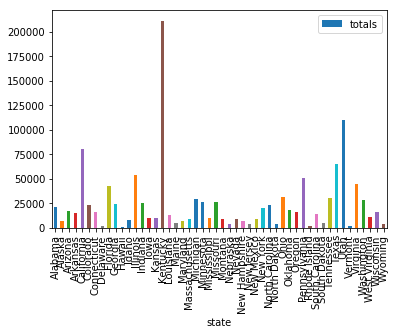

In [89]:
# plot 2010 
g_2010.plot(x='state', y='totals', kind='bar'); #Compare t0 2017

In [90]:
#List 10 states with high gun in 2010
g_2010.sort_values(by=['totals'], axis = 0, ascending = False).head(10)

,month,state,totals
16,2010-04-01,Kentucky,211261
43,2010-04-01,Utah,109391
4,2010-04-01,California,80750
42,2010-04-01,Texas,65012
12,2010-04-01,Illinois,53929
37,2010-04-01,Pennsylvania,50249
45,2010-04-01,Virginia,44137
8,2010-04-01,Florida,42794
34,2010-04-01,Ohio,31312
41,2010-04-01,Tennessee,30453


## Highest gun registration in 2010 by states:
- Kentucky  
- Utah  
- California    
- Texas 
- Illinois  
- Pennsylvania  
- Virginia  
- Florida   
- Ohio  
- Tennessee 

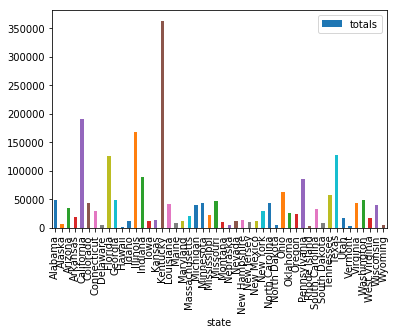

In [91]:
g_2016.plot(x='state', y='totals', kind='bar'); #Compare to 017

Highest gun registration in 2016 by states:
- Kentucky  
- California    
- Illinois  
- Texas 
- Florida   
- Indiana
- Pennsylvania  
- Ohio  
- Tennessee 
- Georgia   

In [92]:
#high gun by state in 2016
g_2016.sort_values(by=['totals'], axis = 0, ascending = False).head(10)

,month,state,totals
16,2016-07-01,Kentucky,363085
4,2016-07-01,California,190218
12,2016-07-01,Illinois,168227
42,2016-07-01,Texas,127207
8,2016-07-01,Florida,125208
13,2016-07-01,Indiana,88340
37,2016-07-01,Pennsylvania,86137
34,2016-07-01,Ohio,63148
41,2016-07-01,Tennessee,57653
9,2016-07-01,Georgia,49183


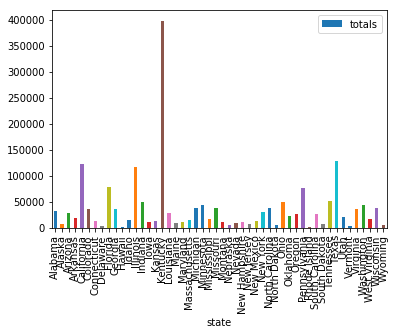

In [93]:
g_017.plot(x='state', y='totals', kind='bar'); # Which state has mg_017.plot(x='state', y='totals', kind='bar'); # Which state has more gun ownershipore gun ownership

List of 10 high gun by states in 2017
- Kentucky
- Texas
- California
- Illinois
- Florida
- Pennsylvania
- Tennessee
- Ohio
- Indianna
- Minnesota

## Research Question 3 (Gun Trend)
### What is the most purchased type of gun in 2017?

In [95]:
#Display g_017
g_017.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [96]:
#Trendy Gun bought (other, mutiple, handgun_long_gun)

gun = ['handgun', 'long_gun', 'other', 'multiple']
purchases = [477315, 417126,26897,17612]

In [97]:
yman = np.arange(len(gun))
yman

array([0, 1, 2, 3])

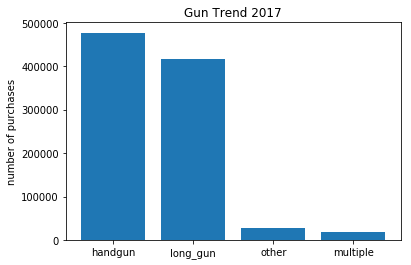

In [98]:
plt.xticks(yman, gun)
plt.ylabel('number of purchases')
plt.title('Gun Trend 2017')
plt.bar(yman, purchases )
plt.legend()

## Most purchased gun in 2017 Handgun Longun other mutiple

#Checking the differences

In [100]:
g_017['handgun'].sum()

477315.0

In [101]:
g_017['long_gun'].sum()

417126.0

In [102]:
g_017['other'].sum()

26897.0

In [103]:
g_017['multiple'].sum()

17612

Answers:
Most purchased gun in 2017
Handgun
Longun
other
mutiple

## Conclusions
In conclusion, The gun and census data shared similar variables such as states and date. Comparing and contrasting both data by countries and date would give the idea about the gun registration per capita in 2010 and 2016. Gun registration per capita in 2010 equal to 0.398%; in 2017, gun registration per capita is equivalent to 0.678%. Additionally, states such as Kentucky, California, Texas, Florida, and Ohio are the most common states with high gun records in 2010, 2016, and 2017. The type of guns that the population in the United States purchased the most in 2017 are primarily handguns; second is the long_guns and other types of firearms.

When it comes to the limitation, there are missing data for U.S colonies such as Puerto Rico, Guam, and others in census_data. It would be appropriate to include them in census data to calculate and check the result of gun per capita. Secondly, Kentucky might be an outlier among the states. By observing Kentucky from 2010,2016, 2017-- the record is surprisingly higher than other American states like Lousiana. In my opinion, it would be reasonable to recheck the data from Kentucky. In different ways, Illinois might be an outlier too because it has been registered a high gun registration in the U.S-- however, Illinois has the strictest gun control in America. It is advised to further the investigation of the states of Illinois.

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [104]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0